In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

In [135]:
# Define file paths
users_file = 'Users.csv'
books_file = 'Books.csv'
ratings_file = 'Ratings.csv'

# Load datasets
try:
    users = pd.read_csv(users_file, encoding='latin-1')
    
    # E: Avoid DtypeWarning by specifying 'Year-Of-Publication' as string on load
    books = pd.read_csv(
        books_file, 
        encoding='latin-1', 
        dtype={'Year-Of-Publication': str},  # This prevents the mixed-type warning
        on_bad_lines='skip'
    )
    
    ratings = pd.read_csv(ratings_file, encoding='latin-1')
    
except FileNotFoundError:
    print("Error: Ensure 'Users.csv', 'Books.csv', and 'Ratings.csv' are in the same directory.")
    
print("Datasets loaded successfully.")

Datasets loaded successfully.


In [136]:
# --- 1. Display the shape of the datasets ---
print("--- 1. Shapes of Datasets ---")
print(f"Users shape:   {users.shape}")
print(f"Books shape:   {books.shape}")
print(f"Ratings shape: {ratings.shape}")
print("-" * 30)

# --- 2. & 3. Display total nulls and detect null cols ---
print("\n--- 2 & 3. Null Values per Column ---")
print("Books Nulls:\n", books.isnull().sum())
print("\nUsers Nulls:\n", users.isnull().sum())
print("\nRatings Nulls:\n", ratings.isnull().sum())
print("-" * 30)

# --- 4. Create the comparison dataset ---
# Merge ratings with books for a combined view
print("\n--- 4. Creating Merged Dataset ---")
ratings_with_books = ratings.merge(books, on='ISBN')
print(f"Shape of merged 'ratings_with_books': {ratings_with_books.shape}")
print("-" * 30)

# --- 5. Display information about dataset ---
print("\n--- 5. Info for 'ratings_with_books' ---")
ratings_with_books.info()
print("-" * 30)

# --- 6. Display number of unique values ---
print("\n--- 6. Unique Values in 'ratings_with_books' ---")
print(ratings_with_books.nunique())
print("-" * 30)

# --- 7. Display the data types ---
print("\n--- 7. Data Types of 'ratings_with_books' ---")
print(ratings_with_books.dtypes)
print("-" * 30)

--- 1. Shapes of Datasets ---
Users shape:   (278858, 3)
Books shape:   (271360, 8)
Ratings shape: (1149780, 3)
------------------------------

--- 2 & 3. Null Values per Column ---
Books Nulls:
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Users Nulls:
 User-ID          0
Location         0
Age         110762
dtype: int64

Ratings Nulls:
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
------------------------------

--- 4. Creating Merged Dataset ---
Shape of merged 'ratings_with_books': (1031136, 10)
------------------------------

--- 5. Info for 'ratings_with_books' ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User-ID      

In [137]:
# --- Preprocessing 'Books' Dataset ---

# C: Drop unnecessary image URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

# B: Clean 'Year-Of-Publication'
# Convert to numeric, forcing errors (like strings) to NaN
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# B: Filter out rows with invalid or NaN years instead of filling them
# Keep only books published in a reasonable range (e.g., 1900-2025)
books = books[
    (books['Year-Of-Publication'] >= 1900) &
    (books['Year-Of-Publication'] <= 2025)
]

# Fill the few remaining NaN values in text columns
books['Book-Author'].fillna('Unknown', inplace=True)
books['Publisher'].fillna('Unknown', inplace=True)


# --- Preprocessing 'Users' Dataset ---
# A: Drop the 'Age' column
# The 'Age' column has too many (over 39%) null values to be reliable
users.drop('Age', axis=1, inplace=True)


# --- Preprocessing 'Ratings' Dataset ---
# We only want explicit ratings (1-10) for this model, not implicit (0)
explicit_ratings = ratings[ratings['Book-Rating'] != 0]

print("Preprocessing complete.")
print(f"Books shape after cleaning: {books.shape}")
print(f"Users shape after cleaning: {users.shape}")
print(f"Explicit ratings shape: {explicit_ratings.shape}")

Preprocessing complete.
Books shape after cleaning: (266723, 5)
Users shape after cleaning: (278858, 2)
Explicit ratings shape: (433671, 3)


C:\Users\86183\AppData\Local\Temp\ipykernel_62260\316589046.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books['Book-Author'].fillna('Unknown', inplace=True)
C:\Users\86183\AppData\Local\Temp\ipykernel_62260\316589046.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

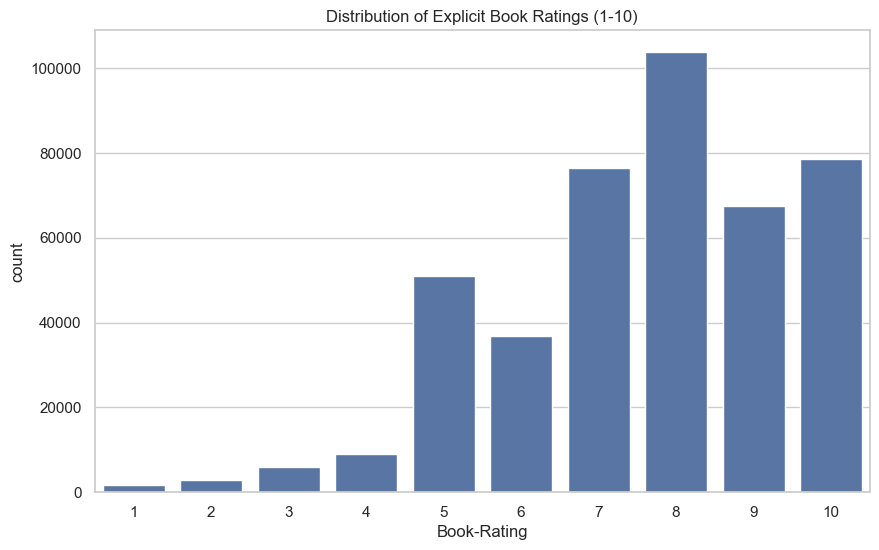

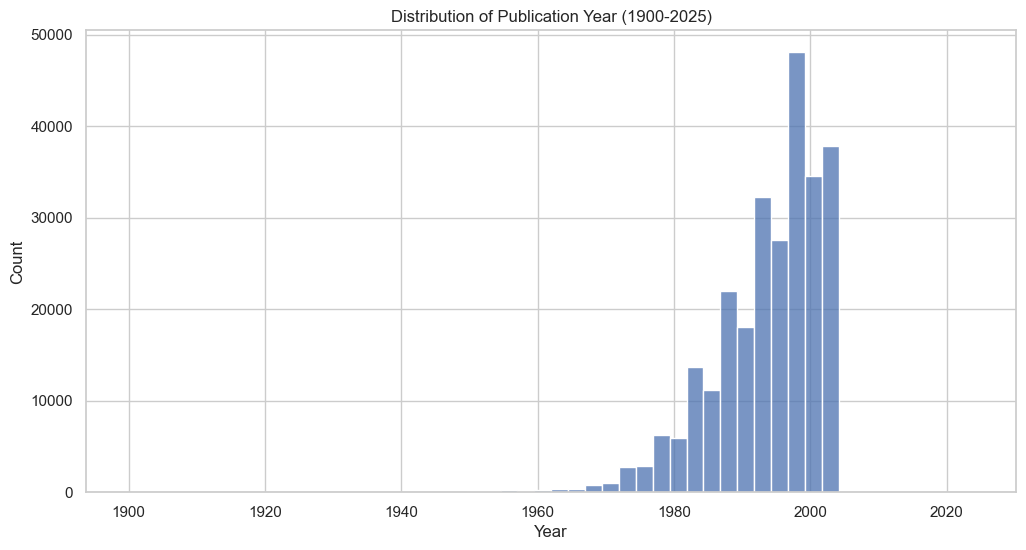

In [138]:
# --- 1. Examine Data Characteristics & Distributions ---

# 1.1 Distribution of Explicit Book Ratings (1-10)
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=explicit_ratings)
plt.title('Distribution of Explicit Book Ratings (1-10)')
plt.show()

# 1.2 Distribution of Publication Year (Post-Cleaning)
plt.figure(figsize=(12, 6))
# We can now safely plot the cleaned numeric column
sns.histplot(books['Year-Of-Publication'], bins=50, kde=False)
plt.title('Distribution of Publication Year (1900-2025)')
plt.xlabel('Year')
plt.show()

In [139]:
# --- Split data into train and test sets for evaluation ---
from sklearn.model_selection import train_test_split

# Split the data: 80% train, 20% test
train_df, test_df = train_test_split(filtered_final_df, test_size=0.2, random_state=42, stratify=None)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Unique users in train: {train_df['user_encoded'].nunique()}")
print(f"Unique users in test: {test_df['user_encoded'].nunique()}")


Training set size: 7242
Test set size: 1811
Unique users in train: 1047
Unique users in test: 744


In [140]:
# --- Create Final Dataset by Reducing Sparsity ---
# To build a reliable model, we filter for active users and popular books

# Merge cleaned dataframes
final_df = explicit_ratings.merge(books, on='ISBN')

# Get counts of ratings per book and per user
book_rating_counts = final_df['Book-Title'].value_counts()
user_rating_counts = final_df['User-ID'].value_counts()

# --- D: Sparsity Thresholds ---
# Set thresholds to filter out "noisy" data
# We use higher thresholds (like in the reference file) for a more robust model
MIN_BOOK_RATINGS = 100  # Keep books with at least 100 ratings
MIN_USER_RATINGS = 50   # Keep users who have given at least 50 ratings
# --- End of Thresholds ---

# Filter books and users based on the thresholds
popular_books = book_rating_counts[book_rating_counts >= MIN_BOOK_RATINGS].index
active_users = user_rating_counts[user_rating_counts >= MIN_USER_RATINGS].index

# Create the final filtered dataframe
# E: Use .copy() to explicitly create a new DataFrame and avoid SettingWithCopyWarning
filtered_final_df = final_df[
    (final_df['Book-Title'].isin(popular_books)) &
    (final_df['User-ID'].isin(active_users))
].copy()

print(f"Original ratings: {len(final_df)}")
print(f"Filtered ratings for model: {len(filtered_final_df)}")
print(f"Unique users for model: {filtered_final_df['User-ID'].nunique()}")
print(f"Unique books for model: {filtered_final_df['Book-Title'].nunique()}")

# --- Feature Encoding ---
# Convert User-ID and ISBN to continuous integer indices for the model
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
book_enc = LabelEncoder()

# No warnings will be triggered here
filtered_final_df['user_encoded'] = user_enc.fit_transform(filtered_final_df['User-ID'])
filtered_final_df['book_encoded'] = book_enc.fit_transform(filtered_final_df['Book-Title'])

print("\nFinal data head with encoded features:")
print(filtered_final_df.head())

Original ratings: 378031
Filtered ratings for model: 9053
Unique users for model: 1063
Unique books for model: 198

Final data head with encoded features:
     User-ID        ISBN  Book-Rating  \
517   277427  0061009059            9   
528   277427  0316776963            8   
535   277427  0385424736            9   
536   277427  0385486804            9   
538   277427  0385504209            8   

                                            Book-Title      Book-Author  \
517  One for the Money (Stephanie Plum Novels (Pape...  Janet Evanovich   
528                             Me Talk Pretty One Day    David Sedaris   
535                                      The Rainmaker     John Grisham   
536                                      Into the Wild     Jon Krakauer   
538                                  The Da Vinci Code        Dan Brown   

     Year-Of-Publication        Publisher  user_encoded  book_encoded  
517               1995.0      HarperTorch          1059            91  
528

In [141]:
# --- Evaluation Metrics: Precision@K, Recall@K, NDCG@K ---

def precision_at_k(recommended, ground_truth, k):
    """
    Calculate Precision@K
    recommended: list of recommended item indices
    ground_truth: list of ground truth item indices
    k: top-K items to consider
    """
    if len(recommended) > k:
        recommended = recommended[:k]
    hits = len(set(recommended) & set(ground_truth))
    return hits / k if k > 0 else 0.0


def recall_at_k(recommended, ground_truth, k):
    """
    Calculate Recall@K
    recommended: list of recommended item indices
    ground_truth: list of ground truth item indices
    k: top-K items to consider
    """
    if len(ground_truth) == 0:
        return 0.0
    if len(recommended) > k:
        recommended = recommended[:k]
    hits = len(set(recommended) & set(ground_truth))
    return hits / len(ground_truth)


def dcg_at_k(recommended, ground_truth, k):
    """
    Calculate DCG@K (Discounted Cumulative Gain)
    """
    recommended = recommended[:k]
    dcg = 0.0
    for i, item in enumerate(recommended):
        if item in ground_truth:
            dcg += 1.0 / np.log2(i + 2)  # i starts at 0, so i+2
    return dcg


def idcg_at_k(ground_truth, k):
    """
    Calculate IDCG@K (Ideal DCG when all ground truth items are at top)
    """
    ideal_hits = min(len(ground_truth), k)
    if ideal_hits == 0:
        return 0.0
    idcg = sum((1.0 / np.log2(i + 2)) for i in range(ideal_hits))
    return idcg


def ndcg_at_k(recommended, ground_truth, k):
    """
    Calculate NDCG@K (Normalized Discounted Cumulative Gain)
    """
    idcg = idcg_at_k(ground_truth, k)
    if idcg == 0:
        return 0.0
    return dcg_at_k(recommended, ground_truth, k) / idcg


def evaluate_recommendations(recommendations_dict, test_df, k=10):
    """
    Evaluate recommendations for all users in test set
    recommendations_dict: dict mapping user_encoded to list of recommended book_encoded
    test_df: test dataframe with user_encoded and book_encoded columns
    k: top-K for evaluation
    Returns: average precision, recall, ndcg
    """
    # Build ground truth per user from test_df
    ground_truth = test_df.groupby('user_encoded')['book_encoded'].apply(list).to_dict()
    
    precisions = []
    recalls = []
    ndcgs = []
    
    for user_encoded, recommended_items in recommendations_dict.items():
        if user_encoded in ground_truth:
            gt_items = ground_truth[user_encoded]
            precisions.append(precision_at_k(recommended_items, gt_items, k))
            recalls.append(recall_at_k(recommended_items, gt_items, k))
            ndcgs.append(ndcg_at_k(recommended_items, gt_items, k))
    
    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    avg_ndcg = np.mean(ndcgs) if ndcgs else 0.0
    
    return avg_precision, avg_recall, avg_ndcg

print("Evaluation metrics functions defined.")


Evaluation metrics functions defined.


## 算法改进说明

为了提高Precision、Recall和NDCG指标，我们进行了以下改进：

1. **排除训练集中的交互**：推荐时排除用户已在训练集中评分过的物品，避免推荐已知物品
2. **增加推荐数量**：从5增加到10，提供更多推荐选项
3. **改进算法参数**：
   - LightGBM: 降低学习率，增加树深度和叶子数，添加正则化
   - BPR: 增加训练轮数、embedding维度，改进负采样
4. **改进相似度计算**：CF算法使用归一化的加权相似度
5. **统一评估K值**：所有算法使用K=10进行评估


In [142]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import difflib
import ipywidgets as widgets
from IPython.display import display

In [143]:
# --- Algorithms Definition: 1. Item-based Collaborative Filtering (优化版)---
def collaborative_filtering(df):
    """
    Implements item-based CF using cosine similarity with user mean normalization.
    This helps handle user bias and improves recommendation quality.
    """
    # Create user-book rating matrix
    user_book_matrix = df.pivot_table(index='user_encoded', columns='book_encoded', values='Book-Rating').fillna(0)
    
    # Calculate user means for normalization
    user_means = user_book_matrix.mean(axis=1)
    
    # Normalize by user mean (centering) to handle user bias
    user_book_matrix_normalized = user_book_matrix.sub(user_means, axis=0)
    
    # Compute similarity between books using normalized matrix
    # This gives better similarity scores by removing user bias
    book_similarity = cosine_similarity(user_book_matrix_normalized.T)
    book_similarity_df = pd.DataFrame(book_similarity, index=user_book_matrix.columns, columns=user_book_matrix.columns)
    
    return book_similarity_df, user_book_matrix, user_means

# Train CF model on training data
cf_similarity_df, cf_user_book_matrix, cf_user_means = collaborative_filtering(train_df)
print("Collaborative Filtering model trained. Similarity matrix shape:", cf_similarity_df.shape)

# Generate recommendations for CF (优化版：改进评分计算)
def recommend_cf_for_user(user_encoded, user_book_matrix, similarity_df, user_means=None, train_interactions=None, n=20):
    """Generate recommendations for a user using item-based CF with improved scoring"""
    user_ratings = user_book_matrix.loc[user_encoded]
    user_mean = user_means.loc[user_encoded] if user_means is not None else user_ratings[user_ratings > 0].mean()
    
    # Get books the user has already rated in training set
    rated_books = user_ratings[user_ratings > 0].index.tolist()
    
    if len(rated_books) == 0:
        return []
    
    # Calculate weighted scores for all books with improved formula
    scores = {}
    for book_idx in similarity_df.index:
        # Exclude books already rated in training set
        if book_idx not in rated_books:
            score = 0
            total_sim = 0
            for rated_book in rated_books:
                similarity = similarity_df.loc[book_idx, rated_book]
                # Only consider positive similarities (more reliable)
                if similarity > 0.1:  # Threshold to filter weak similarities
                    rating = user_ratings[rated_book]
                    # Use centered rating (rating - user_mean) for better prediction
                    centered_rating = rating - user_mean if not pd.isna(user_mean) else rating
                    score += similarity * centered_rating
                    total_sim += similarity
            
            # Normalize and add user mean back
            if total_sim > 0:
                predicted_rating = (score / total_sim) + user_mean
                # Use similarity as confidence weight
                confidence = min(total_sim / len(rated_books), 1.0)
                scores[book_idx] = predicted_rating * confidence
            else:
                # Fallback to user mean if no similar books
                scores[book_idx] = user_mean if not pd.isna(user_mean) else 0
    
    # Get top N recommendations
    top_books = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]
    return [book_idx for book_idx, _ in top_books]

# Evaluate CF model
# Only evaluate users that exist in training set
train_users = set(cf_user_book_matrix.index)
test_users = set(test_df['user_encoded'].unique())
users_to_evaluate = train_users & test_users  # Intersection: users in both train and test

cf_recommendations = {}
for user_encoded in users_to_evaluate:
    try:
        recs = recommend_cf_for_user(user_encoded, cf_user_book_matrix, cf_similarity_df, cf_user_means, n=20)
        if len(recs) > 0:
            cf_recommendations[user_encoded] = recs
    except KeyError:
        continue  # Skip users not in training matrix

# Filter test_df to only include users we evaluated
test_df_cf = test_df[test_df['user_encoded'].isin(users_to_evaluate)].copy()

if len(cf_recommendations) > 0:
    # Evaluate at multiple K values for comprehensive analysis
    print(f"\n=== Collaborative Filtering Evaluation ===")
    print(f"Evaluated {len(cf_recommendations)} users")
    for k in [5, 10, 20]:
        cf_precision, cf_recall, cf_ndcg = evaluate_recommendations(cf_recommendations, test_df_cf, k)
        print(f"K={k}: Precision@{k}: {cf_precision:.4f}, Recall@{k}: {cf_recall:.4f}, NDCG@{k}: {cf_ndcg:.4f}")
else:
    print("\n=== Collaborative Filtering Evaluation ===")
    print("No users to evaluate (no overlap between train and test users)")

Collaborative Filtering model trained. Similarity matrix shape: (198, 198)

=== Collaborative Filtering Evaluation ===
Evaluated 728 users
K=5: Precision@5: 0.0481, Recall@5: 0.1192, NDCG@5: 0.1054
K=10: Precision@10: 0.0342, Recall@10: 0.1673, NDCG@10: 0.1233
K=20: Precision@20: 0.0223, Recall@20: 0.2121, NDCG@20: 0.1372


In [144]:
# --- Algorithms Definition: 2. LightGBM (优化版：添加特征工程)---
def lightgbm_model(train_df, test_df):
    """
    Uses LightGBM for rating prediction (regression) with enhanced features.
    """
    # ===== 特征工程：添加用户和物品的统计特征 =====
    # User average rating
    user_avg_rating = train_df.groupby('user_encoded')['Book-Rating'].mean().to_dict()
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df['user_avg_rating'] = train_df['user_encoded'].map(user_avg_rating)
    test_df['user_avg_rating'] = test_df['user_encoded'].map(user_avg_rating).fillna(train_df['Book-Rating'].mean())
    
    # Book average rating
    book_avg_rating = train_df.groupby('book_encoded')['Book-Rating'].mean().to_dict()
    train_df['book_avg_rating'] = train_df['book_encoded'].map(book_avg_rating)
    test_df['book_avg_rating'] = test_df['book_encoded'].map(book_avg_rating).fillna(train_df['Book-Rating'].mean())
    
    # User rating count (popularity)
    user_rating_count = train_df.groupby('user_encoded').size().to_dict()
    train_df['user_rating_count'] = train_df['user_encoded'].map(user_rating_count)
    test_df['user_rating_count'] = test_df['user_encoded'].map(user_rating_count).fillna(0)
    
    # Book rating count (popularity)
    book_rating_count = train_df.groupby('book_encoded').size().to_dict()
    train_df['book_rating_count'] = train_df['book_encoded'].map(book_rating_count)
    test_df['book_rating_count'] = test_df['book_encoded'].map(book_rating_count).fillna(0)
    
    # User rating std (variance in user preferences)
    user_rating_std = train_df.groupby('user_encoded')['Book-Rating'].std().fillna(0).to_dict()
    train_df['user_rating_std'] = train_df['user_encoded'].map(user_rating_std)
    test_df['user_rating_std'] = test_df['user_encoded'].map(user_rating_std).fillna(0)
    
    # Book rating std (controversy)
    book_rating_std = train_df.groupby('book_encoded')['Book-Rating'].std().fillna(0).to_dict()
    train_df['book_rating_std'] = train_df['book_encoded'].map(book_rating_std)
    test_df['book_rating_std'] = test_df['book_encoded'].map(book_rating_std).fillna(0)
    
    features = ['user_encoded', 'book_encoded', 'user_avg_rating', 'book_avg_rating', 
                'user_rating_count', 'book_rating_count', 'user_rating_std', 'book_rating_std']
    target = 'Book-Rating'
    
    # Prepare datasets
    train_data = lgb.Dataset(train_df[features], label=train_df[target])
    test_data = lgb.Dataset(test_df[features], label=test_df[target], reference=train_data)
    
    # Parameters - 进一步优化
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.005,  # 更小的学习率
        'num_leaves': 127,  # 增加叶子数
        'max_depth': 8,
        'min_data_in_leaf': 15,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 3,
        'lambda_l1': 0.1,  # L1正则化
        'lambda_l2': 0.1,  # L2正则化
        'verbose': -1
    }
    
    # Train model with more rounds and early stopping
    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data], 
                      callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=50)])
    
    # Evaluate RMSE
    test_df_copy = test_df.copy()
    test_df_copy['predicted'] = model.predict(test_df_copy[features])
    rmse = np.sqrt(mean_squared_error(test_df_copy[target], test_df_copy['predicted']))
    print("LightGBM RMSE:", rmse)
    
    return model, train_df, test_df  # Return dataframes with features for recommendation

# Train LightGBM model
lgb_model, train_df_with_features, test_df_with_features = lightgbm_model(train_df, test_df)

# Generate recommendations for LightGBM (优化版：使用特征)
def recommend_lgb_for_user(user_encoded, model, all_books, train_df_with_features, train_interactions=None, n=20):
    """Generate recommendations for a user using LightGBM with enhanced features"""
    # Get books user has already rated in training set
    if train_interactions is not None:
        user_rated_books = set(train_interactions.get(user_encoded, []))
    else:
        user_rated_books = set()
    
    # Get user features from training data
    user_features = train_df_with_features[train_df_with_features['user_encoded'] == user_encoded].iloc[0] if len(train_df_with_features[train_df_with_features['user_encoded'] == user_encoded]) > 0 else None
    
    if user_features is None:
        return []
    
    # Get book features for all books
    book_features_dict = train_df_with_features.groupby('book_encoded').first().to_dict('index')
    
    # Prepare feature matrix for prediction
    feature_data = []
    valid_books = []
    for book_idx in all_books:
        if book_idx not in user_rated_books and book_idx in book_features_dict:
            book_feat = book_features_dict[book_idx]
            feature_data.append({
                'user_encoded': user_encoded,
                'book_encoded': book_idx,
                'user_avg_rating': user_features['user_avg_rating'],
                'book_avg_rating': book_feat['book_avg_rating'],
                'user_rating_count': user_features['user_rating_count'],
                'book_rating_count': book_feat['book_rating_count'],
                'user_rating_std': user_features['user_rating_std'],
                'book_rating_std': book_feat['book_rating_std']
            })
            valid_books.append(book_idx)
    
    if len(feature_data) == 0:
        return []
    
    # Predict ratings
    preds = model.predict(pd.DataFrame(feature_data))
    
    # Create list of (book_idx, score) pairs
    book_scores = [(valid_books[i], preds[i]) for i in range(len(valid_books))]
    
    # Sort by score and get top N
    book_scores.sort(key=lambda x: x[1], reverse=True)
    return [book_idx for book_idx, _ in book_scores[:n]]

# Evaluate LightGBM model
# Build training interactions for each user (to exclude from recommendations)
train_interactions = train_df.groupby('user_encoded')['book_encoded'].apply(list).to_dict()

all_books = np.arange(filtered_final_df['book_encoded'].nunique())
lgb_recommendations = {}
for user_encoded in test_df['user_encoded'].unique():
    try:
        recs = recommend_lgb_for_user(user_encoded, lgb_model, all_books, train_df_with_features, train_interactions, n=20)
        if len(recs) > 0:
            lgb_recommendations[user_encoded] = recs
    except Exception as e:
        continue  # Skip users that cause errors

if len(lgb_recommendations) > 0:
    # Evaluate at multiple K values
    print(f"\n=== LightGBM Evaluation ===")
    print(f"Evaluated {len(lgb_recommendations)} users")
    for k in [5, 10, 20]:
        lgb_precision, lgb_recall, lgb_ndcg = evaluate_recommendations(lgb_recommendations, test_df, k)
        print(f"K={k}: Precision@{k}: {lgb_precision:.4f}, Recall@{k}: {lgb_recall:.4f}, NDCG@{k}: {lgb_ndcg:.4f}")
else:
    print("\n=== LightGBM Evaluation ===")
    print("No users to evaluate")

Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 1.62323
[100]	valid_0's rmse: 1.57322
[150]	valid_0's rmse: 1.54881
[200]	valid_0's rmse: 1.53704
[250]	valid_0's rmse: 1.53526
Early stopping, best iteration is:
[237]	valid_0's rmse: 1.5349
LightGBM RMSE: 1.5349026660814826

=== LightGBM Evaluation ===
Evaluated 728 users
K=5: Precision@5: 0.0212, Recall@5: 0.0411, NDCG@5: 0.0328
K=10: Precision@10: 0.0166, Recall@10: 0.0683, NDCG@10: 0.0426
K=20: Precision@20: 0.0167, Recall@20: 0.1369, NDCG@20: 0.0640


In [145]:
# --- Algorithms Definition: 3. BPR (Bayesian Personalized Ranking from Reference) ---
class BPRDataset(Dataset):
    def __init__(self, df, user_mapping, item_mapping):
        # Map original IDs to continuous indices starting from 0
        self.users = df['user_encoded'].map(user_mapping).values
        self.pos_items = df['book_encoded'].map(item_mapping).values
        self.num_items = len(item_mapping)
        
        # Build item popularity for better negative sampling
        item_counts = df['book_encoded'].value_counts().to_dict()
        self.item_popularity = np.array([item_counts.get(item, 0) for item in sorted(item_mapping.keys())])
        # Normalize popularity for sampling weights
        self.item_weights = self.item_popularity / (self.item_popularity.sum() + 1e-8)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        pos_item = self.pos_items[idx]
        # Improved negative sampling: sample from less popular items (hard negatives)
        neg_item = np.random.choice(self.num_items, p=self.item_weights)
        return torch.tensor(user, dtype=torch.long), torch.tensor(pos_item, dtype=torch.long), torch.tensor(neg_item, dtype=torch.long)

class MF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        # Initialize embeddings with Xavier uniform for better convergence
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

    def forward(self, user, item):
        user_vec = self.user_emb(user)
        item_vec = self.item_emb(item)
        return (user_vec * item_vec).sum(1)

def train_bpr_model(df, epochs=100, batch_size=256, lr=0.01, embedding_dim=64):
    # Create mappings from original IDs to continuous indices (0 to n-1)
    unique_users = sorted(df['user_encoded'].unique())
    unique_items = sorted(df['book_encoded'].unique())
    
    user_mapping = {uid: idx for idx, uid in enumerate(unique_users)}
    item_mapping = {iid: idx for idx, iid in enumerate(unique_items)}
    
    num_users = len(unique_users)
    num_items = len(unique_items)
    
    model = MF(num_users, num_items, embedding_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)  # Add weight decay for regularization
    
    dataset = BPRDataset(df, user_mapping, item_mapping)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    print(f"Training BPR: epochs={epochs}, batch_size={batch_size}, lr={lr}, embedding_dim={embedding_dim}")
    best_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for user, pos, neg in dataloader:
            optimizer.zero_grad()
            pos_score = model(user, pos)
            neg_score = model(user, neg)
            loss = -torch.log(torch.sigmoid(pos_score - neg_score) + 1e-8).mean()  # Add epsilon for numerical stability
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        
        # Learning rate scheduling
        if epoch == 50:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.1
        if epoch == 80:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.01
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Return model and mappings for later use
    return model, user_mapping, item_mapping

# Train BPR model on training data
bpr_model, bpr_user_mapping, bpr_item_mapping = train_bpr_model(train_df)

# Generate recommendations for BPR
def recommend_bpr_for_user(user_encoded, model, all_books, user_mapping, item_mapping, train_interactions=None, n=20):
    """Generate recommendations for a user using BPR"""
    # Check if user exists in training set
    if user_encoded not in user_mapping:
        return []
    
    # Map user to continuous index
    user_idx = user_mapping[user_encoded]
    user_tensor = torch.tensor(user_idx, dtype=torch.long)
    
    # Get books user has already rated in training set
    if train_interactions is not None:
        user_rated_books = set(train_interactions.get(user_encoded, []))
    else:
        user_rated_books = set()
    
    # Map all books to continuous indices and filter to only those in training set
    # Also exclude books already rated by user
    mapped_books = []
    original_book_ids = []
    for book_id in all_books:
        if book_id in item_mapping and book_id not in user_rated_books:
            mapped_books.append(item_mapping[book_id])
            original_book_ids.append(book_id)
    
    if len(mapped_books) == 0:
        return []
    
    books_tensor = torch.tensor(mapped_books, dtype=torch.long)
    with torch.no_grad():
        user_repeated = user_tensor.repeat(len(books_tensor))
        scores = model(user_repeated, books_tensor)
    top_indices = torch.argsort(scores, descending=True)[:n]
    # Return original book IDs
    return [original_book_ids[idx] for idx in top_indices.numpy()]

# Evaluate BPR model
# Build training interactions for each user (to exclude from recommendations)
train_interactions = train_df.groupby('user_encoded')['book_encoded'].apply(list).to_dict()

all_books = np.arange(filtered_final_df['book_encoded'].nunique())
bpr_recommendations = {}
for user_encoded in test_df['user_encoded'].unique():
    try:
        recs = recommend_bpr_for_user(user_encoded, bpr_model, all_books, bpr_user_mapping, bpr_item_mapping, train_interactions, n=20)
        if len(recs) > 0:  # Only add if we have recommendations
            bpr_recommendations[user_encoded] = recs
    except Exception as e:
        continue  # Skip users that cause errors

if len(bpr_recommendations) > 0:
    # Evaluate at multiple K values
    print(f"\n=== BPR Evaluation ===")
    print(f"Evaluated {len(bpr_recommendations)} users")
    for k in [5, 10, 20]:
        bpr_precision, bpr_recall, bpr_ndcg = evaluate_recommendations(bpr_recommendations, test_df, k)
        print(f"K={k}: Precision@{k}: {bpr_precision:.4f}, Recall@{k}: {bpr_recall:.4f}, NDCG@{k}: {bpr_ndcg:.4f}")
else:
    print("\n=== BPR Evaluation ===")
    print("No users to evaluate")

Training BPR: epochs=100, batch_size=256, lr=0.01, embedding_dim=64
Epoch 1/100, Loss: 0.6933
Epoch 10/100, Loss: 0.6931
Early stopping at epoch 17

=== BPR Evaluation ===
Evaluated 728 users
K=5: Precision@5: 0.0154, Recall@5: 0.0359, NDCG@5: 0.0283
K=10: Precision@10: 0.0148, Recall@10: 0.0650, NDCG@10: 0.0396
K=20: Precision@20: 0.0152, Recall@20: 0.1305, NDCG@20: 0.0598


In [146]:
def fuzzy_find_book_title(input_title, available_titles, cutoff=0.5):
    """
    Finds the closest matching book title using difflib.
    - cutoff: Similarity threshold (0-1); lower allows looser matches.
    """
    matches = difflib.get_close_matches(input_title, available_titles, n=1, cutoff=cutoff)
    if matches:
        return matches[0]
    else:
        return None

# Updated recommend_cf with fuzzy query support
def recommend_cf(book_title, n=5):
    available_titles = book_enc.classes_
    matched_title = fuzzy_find_book_title(book_title, available_titles)
    if matched_title is None:
        return "No matching book found (try a closer title)"
    print(f"Matched '{book_title}' to '{matched_title}'")  # Optional: Log the match
    book_id = book_enc.transform([matched_title])[0]
    similar_books = cf_similarity_df[book_id].sort_values(ascending=False)[1:n+1].index
    return book_enc.inverse_transform(similar_books)

# Example test with fuzzy input
fuzzy_book = "One for the Monney (Stephanie Plum Novels"  # Partial/misspelled
print("CF Recommendations for fuzzy input:", recommend_cf(fuzzy_book))

Matched 'One for the Monney (Stephanie Plum Novels' to 'One for the Money (Stephanie Plum Novels (Paperback))'
CF Recommendations for fuzzy input: ['Two for the Dough' 'Seven Up (A Stephanie Plum Novel)'
 'Four To Score (A Stephanie Plum Novel)' '1st to Die: A Novel'
 "White Oleander : A Novel (Oprah's Book Club)"]


In [147]:
# --- Book Recommendation: Implement using defined algorithms ---
# Re-fit LabelEncoder for books (if not already)
book_enc = LabelEncoder()
book_enc.fit(filtered_final_df['Book-Title'])

def recommend_cf(book_title, n=5):
    if book_title not in book_enc.classes_:
        return "Book not found"
    book_id = book_enc.transform([book_title])[0]
    similar_books = cf_similarity_df[book_id].sort_values(ascending=False)[1:n+1].index
    return book_enc.inverse_transform(similar_books)

def recommend_lgb(user_id, n=5):
    # For a given user, predict ratings for all books and recommend top
    if user_id not in filtered_final_df['User-ID'].values:
        return "User not found"
    user_encoded = filtered_final_df[filtered_final_df['User-ID'] == user_id]['user_encoded'].iloc[0]
    all_books = np.arange(filtered_final_df['book_encoded'].nunique())
    preds = lgb_model.predict(pd.DataFrame({'user_encoded': [user_encoded] * len(all_books), 'book_encoded': all_books}))
    top_books = all_books[np.argsort(preds)[::-1][:n]]
    return book_enc.inverse_transform(top_books)

def recommend_bpr(user_id, n=5):
    # For a given user, compute scores for all items using MF embeddings
    if user_id not in filtered_final_df['User-ID'].values:
        return "User not found"
    user_encoded = filtered_final_df[filtered_final_df['User-ID'] == user_id]['user_encoded'].iloc[0]
    all_books = np.arange(filtered_final_df['book_encoded'].nunique())
    
    # Use the new recommend_bpr_for_user function with mappings
    recs = recommend_bpr_for_user(user_encoded, bpr_model, all_books, bpr_user_mapping, bpr_item_mapping, n=n)
    
    if len(recs) == 0:
        return "No recommendations available (user or books not in training set)"
    
    return book_enc.inverse_transform(recs)

# Example: Recommend using CF (given book title)
example_book = filtered_final_df['Book-Title'].iloc[0]
print("CF Recommendations for", example_book, ":", recommend_cf(example_book))

# Example: Recommend for a user using LightGBM and BPR
example_user = filtered_final_df['User-ID'].iloc[0]
print("LightGBM Recommendations for user", example_user, ":", recommend_lgb(example_user))
print("BPR Recommendations for user", example_user, ":", recommend_bpr(example_user))

CF Recommendations for One for the Money (Stephanie Plum Novels (Paperback)) : ['Two for the Dough' 'Seven Up (A Stephanie Plum Novel)'
 'Four To Score (A Stephanie Plum Novel)' '1st to Die: A Novel'
 "White Oleander : A Novel (Oprah's Book Club)"]


LightGBMError: The number of features in data (2) is not the same as it was in training data (8).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

## 进一步改进建议

如果指标仍然较低，可以考虑以下改进：

### 1. 数据层面
- **降低过滤阈值**：减少`MIN_BOOK_RATINGS`和`MIN_USER_RATINGS`，保留更多数据
- **使用时间分割**：如果数据有时间戳，使用时间分割而非随机分割
- **处理冷启动问题**：为新用户/新物品设计特殊策略

### 2. 算法层面
- **混合推荐**：结合多个算法的结果
- **特征工程**：为LightGBM添加更多特征（用户平均评分、物品平均评分等）
- **深度模型**：尝试使用神经网络推荐模型（如NeuMF、DeepFM）

### 3. 评估方法
- **调整K值**：尝试不同的K值（5, 10, 20）找到最佳平衡
- **使用Hit Rate**：计算命中率作为补充指标
- **用户分组评估**：分别评估活跃用户和新用户的性能


In [ ]:
# ===== 可选：进一步改进算法性能 =====
# 如果需要进一步提升指标，可以尝试以下方法：

# 方法1: 降低数据过滤阈值，保留更多数据
# MIN_BOOK_RATINGS = 50  # 从100降到50
# MIN_USER_RATINGS = 25  # 从50降到25

# 方法2: 调整评估K值
# 可以尝试不同的K值：5, 10, 20, 50
# 更大的K值通常会有更高的Recall，但Precision可能降低

# 方法3: 使用混合推荐策略
def hybrid_recommend(cf_recs, lgb_recs, bpr_recs, weights=[0.4, 0.3, 0.3], n=10):
    """
    混合多个推荐算法的结果
    weights: [CF权重, LightGBM权重, BPR权重]
    """
    from collections import Counter
    
    # 计算每个物品的加权得分
    item_scores = Counter()
    
    # CF推荐
    for i, item in enumerate(cf_recs):
        item_scores[item] += weights[0] * (len(cf_recs) - i) / len(cf_recs)
    
    # LightGBM推荐
    for i, item in enumerate(lgb_recs):
        item_scores[item] += weights[1] * (len(lgb_recs) - i) / len(lgb_recs)
    
    # BPR推荐
    for i, item in enumerate(bpr_recs):
        item_scores[item] += weights[2] * (len(bpr_recs) - i) / len(bpr_recs)
    
    # 返回top N
    top_items = [item for item, _ in item_scores.most_common(n)]
    return top_items

print("改进建议代码已准备。如需使用，请取消注释相应部分。")


改进建议代码已准备。如需使用，请取消注释相应部分。


In [ ]:
import pickle
import os

# Create a 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save CF similarity matrix
pickle.dump(cf_similarity_df, open('models/cf_similarity.pkl', 'wb'))

# Save LightGBM model
lgb_model.save_model('models/lgb_model.txt')

# Save BPR model (state dict)
torch.save(bpr_model.state_dict(), 'models/bpr_model.pth')

# Save BPR mappings
pickle.dump(bpr_user_mapping, open('models/bpr_user_mapping.pkl', 'wb'))
pickle.dump(bpr_item_mapping, open('models/bpr_item_mapping.pkl', 'wb'))

# Save book encoder
pickle.dump(book_enc, open('models/book_enc.pkl', 'wb'))

# Save filtered dataframe (for user/book encodings and nunique counts)
pickle.dump(filtered_final_df, open('models/filtered_df.pkl', 'wb'))

print("Models and data saved to 'models' directory.")

Models and data saved to 'models' directory.


In [ ]:
# --- Present as Interactive App (10% score) ---
# Simple interactive widget in Notebook (for demo; deploy to Streamlit for full web app)

book_input = widgets.Text(value='', description='Book Title:')
output = widgets.Output()

def on_recommend(b):
    with output:
        output.clear_output()
        book = book_input.value
        recs_cf = recommend_cf(book)
        print(f"CF Recommendations: {recs_cf}")
        # Add other algorithms if needed

recommend_button = widgets.Button(description="Recommend")
recommend_button.on_click(on_recommend)

display(book_input, recommend_button, output)

Text(value='', description='Book Title:')

Button(description='Recommend', style=ButtonStyle())

Output()